# Behavioral Cloning
### Galen Ballew, 2017
### Udacity SDCE ND

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import csv
import cv2
%matplotlib inline
plt.style.use('fivethirtyeight')

## Data Munging and Exploratory Data Analysis

In [6]:
#load in driving data from simulator and add column names
df = pd.read_csv('driving_log.csv', names=['center', 'left', 'right', 'steering_angle',
                                               'throttle', 'brake', 'speed'], header=None)
#precision of values is 7 digits
# 25,781 observations, 6 features, 1 target
print(df.shape)
df.head(1)

(8036, 7)


,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.14829


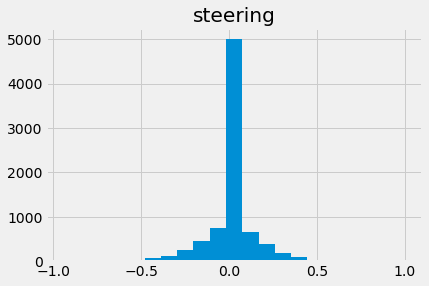

In [8]:
#check distribution of target variable. Gaussian is better. we can see below it has very high kurtosis
df.hist('steering_angle', bins=21);

As it is, there is an excess of steering angles that are very close to neutral. The model will pick up on this and will learn to steer neutral the large majority of the time. Some data augmentation may be needed to make this distribution closer to normal.

## Training
---

In [9]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras.backend as K
import keras
import pickle
import os
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Conv2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [17]:
samples = []

with open('driving_log.csv') as csv_file:
    reader = csv.reader(csv_file)
    for line in reader:
        if abs(float(line[3])) > 0.05:
            samples.append(line)
        else:
            fifty = np.random.random()
            if fifty >= 0.7:
                samples.append(line)

FileNotFoundError: [Errno 2] No such file or directory: 'driving_log.csv'

In [ ]:
#shuffles automatically
train_samples, test_samples = train_test_split(samples, test_size=0.2)

#### Data Augmentation:
In the current pipeline, the only data augmentation I'll be doing is cropping and normalization of the pixel data. There are some other possibilities however:

1) Edge detection  
2) Different color space(s)  
3) Adding lane offset feature by combining from Adv Lane Detection and Vehicle tracking    
4) Resizing images

#### Bootstrapping:  
Inside of `frame_generator()` I am flipping images and the measurements. This results in x2 as many training observations. There could also be additional bootstrapping of the data:

1) Perspective transform to birdseye view  
2) Slight, random skews and warps of images  
3) Random shadows added  

If these approaches where to be taken, it may serve to have multiple models with the final output being an ensemble method. 

**Hyperparameters for data (i.e. not DNN HPs)**:  
angle correction - located inside of frame_generator  
image cropping - located inside of model.Cropping2D  



In [14]:
def frame_generator(samples, batch_size=1):
    num_samples = len(samples)
    while True:
        for step_size in range(0, num_samples, batch_size):
            batch = samples[step_size:step_size+batch_size]
            images = []
            angles = []
            
            for observation in batch:
                #angle correction is tuneable
                for camera, angle_correct in zip([0, 1, 2],[0, 0.1, -0.1]):
                    name = 'img/'+ observation[camera].split('/')[-1]
                    #convert to HSV and extract S channel, resize by factor of 10
                    image = cv2.resize((cv2.cvtColor(plt.imread(name), cv2.COLOR_RGB2HSV)),(32,16))[:,:,1]
                    angle = float(observation[3]) + angle_correct
                    #only train on Saturation
                    images.append(image)
                    angles.append(angle)
            
                X_train_orig = np.array(images)
                y_train_orig = np.array(angles)

                # create flipped image data as well
                X_train_flip = np.array(np.fliplr(images))
                y_train_flip =-np.array(angles)
                
                #resize so to add channel dimension
                X_train_orig = X_train_orig.reshape(X_train_orig.shape[0], 16, 32, 1)
                X_train_flip = X_train_flip.reshape(X_train_flip.shape[0], 16, 32, 1)

                X_train = np.concatenate((X_train_orig, X_train_flip), axis=0)
                y_train = np.concatenate((y_train_orig, y_train_flip), axis=0)

                yield sklearn.utils.shuffle(X_train, y_train)

In [15]:
train_gen = frame_generator(train_samples)
test_gen = frame_generator(test_samples)

NameError: name 'train_samples' is not defined

Originally I trained a fully featured CNN with original image sizes. It took hours to train and the performance was nothing to call home about. I needed to speed up my training time and improve performance. This meant fewer parameters in the network. To do this, the first step was to make the images smaller, which is done during the generator. Next, I implemented a smaller network structure. This architecture was created by Mengxi Wu and can be found [here](https://medium.com/@xslittlegrass/self-driving-car-in-a-simulator-with-a-tiny-neural-network-13d33b871234).

This new architure allowed me to train the entire network in just a few minutes instead of an entire work day.

In [19]:
model = Sequential()
model.add(Lambda(lambda x: x/127.5 - 1.0, input_shape=(16,32,1)))
model.add(Conv2D(12, 3, strides=3, activation='relu'))
model.add(MaxPooling2D((4,4),(4,4)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1))

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 16, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 10, 12)         120       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 2, 12)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 2, 12)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________


In [23]:
adam = keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam, loss="mean_squared_error")

callbacks_list = []
filepath="checkpoints/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=0, verbose=0, mode='auto')
callbacks_list.append(checkpoint)
#callbacks_list.append(early)

In [24]:
history = model.fit_generator(generator=train_gen, steps_per_epoch=len(train_samples), validation_data=test_gen,
                              validation_steps= len(test_samples), epochs=20, callbacks=callbacks_list)

Epoch 1/20
1671/1671 [==============================] - 13s - loss: 0.3309 - val_loss: 0.3073
Epoch 2/20
1671/1671 [==============================] - 12s - loss: 0.3219 - val_loss: 0.3024
Epoch 3/20
1671/1671 [==============================] - 12s - loss: 0.3160 - val_loss: 0.2990
Epoch 4/20
1671/1671 [==============================] - 12s - loss: 0.3125 - val_loss: 0.2962
Epoch 5/20
1671/1671 [==============================] - 12s - loss: 0.3094 - val_loss: 0.2940
Epoch 6/20
1671/1671 [==============================] - 12s - loss: 0.3066 - val_loss: 0.2920
Epoch 7/20
1671/1671 [==============================] - 13s - loss: 0.3053 - val_loss: 0.2902
Epoch 8/20
 902/1671 [===============>..............] - ETA: 5s - loss: 0.3003

KeyboardInterrupt: 

In [ ]:
model.save("model.h5")

In [ ]:
plt.plot(history.history['loss'],'x-')
plt.plot(history.history['val_loss'],'o-')
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.grid()
plt.show()

## First Network

In [ ]:
model = Sequential()
model.add(Lambda(lambda x: x/255 - 0.5, input_shape=(160,320,3)))
#amount of cropping is tuneable
model.add(Cropping2D(cropping=((75, 25), (0, 0))))

model.add(Conv2D(24,5, activation='elu'))
model.add(MaxPooling2D()) #(2,2) pool with no stride, valid padding

model.add(Conv2D(36,5, activation='elu'))
model.add(MaxPooling2D())

model.add(Conv2D(48,5, activation='elu'))
model.add(MaxPooling2D())

model.add(Conv2D(64,3, activation='elu'))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(511, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(127, activation='relu'))
model.add(Dense(31, activation='relu'))
model.add(Dense(1))

In [ ]:
print(model.summary())